![miad4.png](Archivos/miad4.png)

# Laboratorio 2

## Desarrollo de una herramienta analítica usando paquetes especializados para análisis de datos en Python

Para el desarrollo de esta actividad puedes utilizar cualquier librería externa. Te recomendamos leer por completo el enunciado del laboratorio antes de comenzar, de forma que tengas claro el propósito global de la actividad y puedas desarrollar tu solución apuntando a él desde el inicio.

Al desarrollar este laboratorio pondrás a prueba tus habilidades para:

1. Identificar y abordar preguntas de negocio y de *analytics*.
2. Leer datos desde archivos y almacenarlos utilizando métodos de librerías especializadas.
3. Explorar, modificar, limpiar y unir objetos tablas de datos.
4. Implementar análisis combinando métricas descriptivas, visualización, filtrado y agrupación.
5. Implementar análisis basado en modelos estadísticos o de *machine learning*.

##  Contexto: desigualdad y factores de éxito en pruebas Saber 11 en Colombia

El ICFES es el Instituto Colombiano para el Fomento de la Educación Superior y está adscrito al Ministerio de Educación a nivel nacional. Como parte de sus funciones, el ICFES administra las pruebas Saber 11, las cuales evalúan a todos los estudiantes del país al final de su educación secundaria. El examen contiene preguntas que evalúan una variedad de áreas del conocimiento (ej., matemáticas, física, inglés, etc.) y se lleva a cabo dos veces al año, ajustándose a los diferentes calendarios académicos que siguen las instituciones educativas. Al momento de inscribirse a las pruebas, los estudiantes diligencian un formulario que recoge información sociodemográfica y relacionada con la institución a la que pertenecen. El fin es obtener información con respecto al desempeño de los estudiantes en la prueba y de sus características.

![msaberpro.png](Archivos/saberpro.png)

Al igual que otros países de la región, Colombia tiene grandes retos en términos de desigualdad, particularmente en el contexto de educación primaria y secundaria. Por esta razón, para el Estado colombiano es muy valioso el amplio registro de datos que el ICFES genera alrededor de las pruebas Saber 11, pues con ellos se pueden generar análisis sobre la calidad de la educación en el país y eventualmente dar lugar a recomendaciones sobre políticas públicas. En particular, la problemática a abordar en este caso de estudio es la desigualdad y factores de éxito en las pruebas Saber 11. 

Los objetivos de este caso de estudio son:

* Entender el contenido de los archivos de datos proporcionados sobre las pruebas Saber 11, generar un reporte acerca de sus características principales y seleccionar las partes de dicho contenido que podrían ser relevantes para el análisis.


* Identificar características de las variables de interés y relaciones entre ellas, por ejemplo, a través de agrupación, visualizaciones y estadísticas descriptivas.


* Proponer un modelo que busque relacionar las variables de interés con el desempeño de los estudiantes y concluir acerca de los posibles hallazgos que se podrían reportar para el *stakeholder*.


* Generar una herramienta que permita a un usuario interactuar con alguno de los parámetros del análisis realizado de forma relevante en el contexto del problema.

## Fase 1: obtener e inspeccionar archivos

En esta fase te harás una idea general del contenido de los datos y generarás un reporte al respecto (ej., imprimiendo mensajes, presentando tablas de resumen, etc.). Además, seleccionarás un segmento de los datos que consideres útil para realizar tu análisis.

Pautas generales:

* Utilizar una librería especializada para leer los archivos de datos y agregarlos según sea necesario (ej., utilizando los métodos `append` o `concat` si eliges cargarlos utilizando la librería `pandas`).
* Inspeccionar el archivo a partir de sus encabezados, columnas y descripciones de las variables según su tipo (ej., numéricas, categóricas).
* Declarar una estructura de datos (ej., una lista) para almacenar un subconjunto de variables que puedan ser relevantes para la problemática de interés.

Preguntas guía:

* ¿Qué dimensiones tienen los datos?
* ¿Con cuántos años y periodos de evaluación se cuenta?
* ¿Cuáles variables pueden ser de interés para la problemática planteada?
* ¿Qué porcentaje de datos faltantes o no válidos hay en las columnas de interés? ¿Qué planteas para manejarlos?

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from dython import nominal
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from itertools import combinations
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
import ipywidgets as widgets
from IPython.display import display

In [2]:
# define functions
def lower_names(df):
    l_names = {col: col.lower() for col in df.columns}
    return df.rename(l_names)

def plot_null_vals(df):
    null_bool = df.select([pl.col(col).is_null() for col in df.columns])
    
    null_array = null_bool.to_numpy().astype(int).T
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.imshow(null_array, aspect='auto', cmap='viridis', interpolation='none')
    
    ax.set_yticks(range(len(df.columns)))
    ax.set_yticklabels(df.columns)
    ax.set_xticks([])
    plt.title('Valores nulos por columna')
    
    return plt.show()

def data_type(df):
    df_type = pl.DataFrame(
        {
            "col_name": df.columns,
            "var_type": [df_h[col].dtype for col in df.columns]
        }
    )

    return df_type

def impute_mode(df):
    
    for col in df.columns:
        n_row = df.shape[0]   
        mode_col = df[col].drop_nulls().mode().item()
        
        if df[col].null_count() > 0:
            df = df.with_columns(
                pl.col(col).fill_null(mode_col))
    return df

In [3]:
# load data
df_h = pl.read_csv("/Users/sebas/OneDrive/Documents/repositorio_cepap/CEPAP/data_source/educacion/2025/Resultados__nicos_Saber_11_20250303.tsv", separator="\t", decimal_comma = True)

df_h.head()

PERIODO,ESTU_TIPODOCUMENTO,ESTU_CONSECUTIVO,COLE_AREA_UBICACION,COLE_BILINGUE,COLE_CALENDARIO,COLE_CARACTER,COLE_COD_DANE_ESTABLECIMIENTO,COLE_COD_DANE_SEDE,COLE_COD_DEPTO_UBICACION,COLE_COD_MCPIO_UBICACION,COLE_CODIGO_ICFES,COLE_DEPTO_UBICACION,COLE_GENERO,COLE_JORNADA,COLE_MCPIO_UBICACION,COLE_NATURALEZA,COLE_NOMBRE_ESTABLECIMIENTO,COLE_NOMBRE_SEDE,COLE_SEDE_PRINCIPAL,ESTU_COD_DEPTO_PRESENTACION,ESTU_COD_MCPIO_PRESENTACION,ESTU_COD_RESIDE_DEPTO,ESTU_COD_RESIDE_MCPIO,ESTU_DEPTO_PRESENTACION,ESTU_DEPTO_RESIDE,ESTU_ESTADOINVESTIGACION,ESTU_ESTUDIANTE,ESTU_FECHANACIMIENTO,ESTU_GENERO,ESTU_MCPIO_PRESENTACION,ESTU_MCPIO_RESIDE,ESTU_NACIONALIDAD,ESTU_PAIS_RESIDE,ESTU_PRIVADO_LIBERTAD,FAMI_CUARTOSHOGAR,FAMI_EDUCACIONMADRE,FAMI_EDUCACIONPADRE,FAMI_ESTRATOVIVIENDA,FAMI_PERSONASHOGAR,FAMI_TIENEAUTOMOVIL,FAMI_TIENECOMPUTADOR,FAMI_TIENEINTERNET,FAMI_TIENELAVADORA,DESEMP_INGLES,PUNT_INGLES,PUNT_MATEMATICAS,PUNT_SOCIALES_CIUDADANAS,PUNT_C_NATURALES,PUNT_LECTURA_CRITICA,PUNT_GLOBAL
i64,str,str,str,str,str,str,i64,i64,i64,i64,i64,str,str,str,str,str,str,str,str,i64,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64
20131,"""CR""","""SB11201310000414""","""URBANO""","""N""","""B""","""ACADÉMICO""",311848000812,311848000812,11,11001,22574,"""BOGOTA""","""FEMENINO""","""COMPLETA""","""BOGOTÁ D.C.""","""NO OFICIAL""","""GIMN FEMENINO""","""GIMN FEMENINO""","""S""",11,11001,11,11001,"""BOGOTÁ""","""BOGOTÁ""","""PUBLICAR""","""ESTUDIANTE""","""08/08/1994""","""F""","""BOGOTÁ D.C.""","""BOGOTÁ D.C.""","""COLOMBIA""","""COLOMBIA""","""N""","""Cuatro""","""Educación profesional completa""","""Educación profesional completa""","""Estrato 6""","""Cuatro""","""Si""","""Si""","""Si""","""Si""","""B+""","""94""","""88""",null,null,null,null
20194,"""TI""","""SB11201940464873""","""RURAL""","""N""","""A""","""TÉCNICO/ACADÉMICO""",141016000305,241016000342,41,41016,194878,"""HUILA""","""MIXTO""","""COMPLETA""","""AIPE""","""OFICIAL""","""INSTITUCION EDUCATIVA JESUS MA…","""DINDAL""","""N""",41,41016,41,41016,"""HUILA""","""HUILA""","""PUBLICAR""","""ESTUDIANTE""","""15/02/2003""","""F""","""AIPE""","""AIPE""","""COLOMBIA""","""COLOMBIA""","""N""","""Dos""","""Postgrado""","""Primaria completa""","""Estrato 2""","""1 a 2""","""No""","""Si""","""Si""","""Si""","""B1""","""71""","""66""",70,65,69,339
20194,"""TI""","""SB11201940464873""","""RURAL""","""N""","""A""","""TÉCNICO/ACADÉMICO""",141016000305,241016000342,41,41016,194878,"""HUILA""","""MIXTO""","""COMPLETA""","""AIPE""","""OFICIAL""","""INSTITUCION EDUCATIVA JESUS MA…","""DINDAL""","""N""",41,41016,41,41016,"""HUILA""","""HUILA""","""PUBLICAR""","""ESTUDIANTE""","""15/02/2003""","""F""","""AIPE""","""AIPE""","""COLOMBIA""","""COLOMBIA""","""N""","""Dos""","""Postgrado""","""Primaria completa""","""Estrato 2""","""1 a 2""","""No""","""Si""","""Si""","""Si""","""B1""","""71""","""66""",70,65,69,339
20122,"""TI""","""SB11201220204399""","""URBANO""","""N""","""A""","""TÉCNICO/ACADÉMICO""",163130000718,163130000718,63,63130,13029,"""QUINDIO""","""MIXTO""","""MAÑANA""","""CALARCÁ""","""OFICIAL""","""INSTITUCION EDUCATIVA ANTONIO …","""ANTONIO NARIÑO""","""S""",63,63130,63,63130,"""QUINDIO""","""QUINDIO""","""PUBLICAR""","""ESTUDIANTE""","""20/05/1996""","""F""","""CALARCÁ""","""CALARCÁ""","""COLOMBIA""","""COLOMBIA""","""N""","""Dos""","""Secundaria (Bachillerato) inco…","""No sabe""","""Estrato 1""","""Cuatro""","""No""","""Si""","""Si""","""No""","""A1""","""48""","""45""",null,null,null,null
20132,"""TI""","""SB11201320464198""","""URBANO""","""N""","""A""","""TÉCNICO""",119001000559,119001000559,19,19001,46391,"""CAUCA""","""FEMENINO""","""MAÑANA""","""POPAYÁN""","""OFICIAL""","""CRISTO REY""","""SEDE CRISTO REY""","""S""",19,19001,19,19001,"""CAUCA""","""CAUCA""","""PUBLICAR""","""ESTUDIANTE""","""19/03/1997""","""F""","""POPAYÁN""","""POPAYÁN""","""COLOMBIA""","""COLOMBIA""","""N""","""Cinco""","""Educación profesional completa""","

In [4]:
# dimensiones
print("las dimensiones de la tabla original correponden a " + str(df_h.shape[0]) + " filas y " + str(df_h.shape[1]) + " columnas.")

las dimensiones de la tabla original correponden a 7109704 filas y 51 columnas.


In [5]:
# clean names
df_h = lower_names(df_h)

df_h.head()

periodo,estu_tipodocumento,estu_consecutivo,cole_area_ubicacion,cole_bilingue,cole_calendario,cole_caracter,cole_cod_dane_establecimiento,cole_cod_dane_sede,cole_cod_depto_ubicacion,cole_cod_mcpio_ubicacion,cole_codigo_icfes,cole_depto_ubicacion,cole_genero,cole_jornada,cole_mcpio_ubicacion,cole_naturaleza,cole_nombre_establecimiento,cole_nombre_sede,cole_sede_principal,estu_cod_depto_presentacion,estu_cod_mcpio_presentacion,estu_cod_reside_depto,estu_cod_reside_mcpio,estu_depto_presentacion,estu_depto_reside,estu_estadoinvestigacion,estu_estudiante,estu_fechanacimiento,estu_genero,estu_mcpio_presentacion,estu_mcpio_reside,estu_nacionalidad,estu_pais_reside,estu_privado_libertad,fami_cuartoshogar,fami_educacionmadre,fami_educacionpadre,fami_estratovivienda,fami_personashogar,fami_tieneautomovil,fami_tienecomputador,fami_tieneinternet,fami_tienelavadora,desemp_ingles,punt_ingles,punt_matematicas,punt_sociales_ciudadanas,punt_c_naturales,punt_lectura_critica,punt_global
i64,str,str,str,str,str,str,i64,i64,i64,i64,i64,str,str,str,str,str,str,str,str,i64,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64
20131,"""CR""","""SB11201310000414""","""URBANO""","""N""","""B""","""ACADÉMICO""",311848000812,311848000812,11,11001,22574,"""BOGOTA""","""FEMENINO""","""COMPLETA""","""BOGOTÁ D.C.""","""NO OFICIAL""","""GIMN FEMENINO""","""GIMN FEMENINO""","""S""",11,11001,11,11001,"""BOGOTÁ""","""BOGOTÁ""","""PUBLICAR""","""ESTUDIANTE""","""08/08/1994""","""F""","""BOGOTÁ D.C.""","""BOGOTÁ D.C.""","""COLOMBIA""","""COLOMBIA""","""N""","""Cuatro""","""Educación profesional completa""","""Educación profesional completa""","""Estrato 6""","""Cuatro""","""Si""","""Si""","""Si""","""Si""","""B+""","""94""","""88""",null,null,null,null
20194,"""TI""","""SB11201940464873""","""RURAL""","""N""","""A""","""TÉCNICO/ACADÉMICO""",141016000305,241016000342,41,41016,194878,"""HUILA""","""MIXTO""","""COMPLETA""","""AIPE""","""OFICIAL""","""INSTITUCION EDUCATIVA JESUS MA…","""DINDAL""","""N""",41,41016,41,41016,"""HUILA""","""HUILA""","""PUBLICAR""","""ESTUDIANTE""","""15/02/2003""","""F""","""AIPE""","""AIPE""","""COLOMBIA""","""COLOMBIA""","""N""","""Dos""","""Postgrado""","""Primaria completa""","""Estrato 2""","""1 a 2""","""No""","""Si""","""Si""","""Si""","""B1""","""71""","""66""",70,65,69,339
20194,"""TI""","""SB11201940464873""","""RURAL""","""N""","""A""","""TÉCNICO/ACADÉMICO""",141016000305,241016000342,41,41016,194878,"""HUILA""","""MIXTO""","""COMPLETA""","""AIPE""","""OFICIAL""","""INSTITUCION EDUCATIVA JESUS MA…","""DINDAL""","""N""",41,41016,41,41016,"""HUILA""","""HUILA""","""PUBLICAR""","""ESTUDIANTE""","""15/02/2003""","""F""","""AIPE""","""AIPE""","""COLOMBIA""","""COLOMBIA""","""N""","""Dos""","""Postgrado""","""Primaria completa""","""Estrato 2""","""1 a 2""","""No""","""Si""","""Si""","""Si""","""B1""","""71""","""66""",70,65,69,339
20122,"""TI""","""SB11201220204399""","""URBANO""","""N""","""A""","""TÉCNICO/ACADÉMICO""",163130000718,163130000718,63,63130,13029,"""QUINDIO""","""MIXTO""","""MAÑANA""","""CALARCÁ""","""OFICIAL""","""INSTITUCION EDUCATIVA ANTONIO …","""ANTONIO NARIÑO""","""S""",63,63130,63,63130,"""QUINDIO""","""QUINDIO""","""PUBLICAR""","""ESTUDIANTE""","""20/05/1996""","""F""","""CALARCÁ""","""CALARCÁ""","""COLOMBIA""","""COLOMBIA""","""N""","""Dos""","""Secundaria (Bachillerato) inco…","""No sabe""","""Estrato 1""","""Cuatro""","""No""","""Si""","""Si""","""No""","""A1""","""48""","""45""",null,null,null,null
20132,"""TI""","""SB11201320464198""","""URBANO""","""N""","""A""","""TÉCNICO""",119001000559,119001000559,19,19001,46391,"""CAUCA""","""FEMENINO""","""MAÑANA""","""POPAYÁN""","""OFICIAL""","""CRISTO REY""","""SEDE CRISTO REY""","""S""",19,19001,19,19001,"""CAUCA""","""CAUCA""","""PUBLICAR""","""ESTUDIANTE""","""19/03/1997""","""F""","""POPAYÁN""","""POPAYÁN""","""COLOMBIA""","""COLOMBIA""","""N""","""Cinco""","""Educación profesional completa""","

In [6]:
# Explorar variables por prefijos
prefjs = ["cole", "estu_", "fami_", "punt_"]

In [7]:
# Columnas colegio
columnas_cole = [col for col in df_h.columns if col.startswith(prefjs[0])]
df_h.select(columnas_cole).head()

cole_area_ubicacion,cole_bilingue,cole_calendario,cole_caracter,cole_cod_dane_establecimiento,cole_cod_dane_sede,cole_cod_depto_ubicacion,cole_cod_mcpio_ubicacion,cole_codigo_icfes,cole_depto_ubicacion,cole_genero,cole_jornada,cole_mcpio_ubicacion,cole_naturaleza,cole_nombre_establecimiento,cole_nombre_sede,cole_sede_principal
str,str,str,str,i64,i64,i64,i64,i64,str,str,str,str,str,str,str,str
"""URBANO""","""N""","""B""","""ACADÉMICO""",311848000812,311848000812,11,11001,22574,"""BOGOTA""","""FEMENINO""","""COMPLETA""","""BOGOTÁ D.C.""","""NO OFICIAL""","""GIMN FEMENINO""","""GIMN FEMENINO""","""S"""
"""RURAL""","""N""","""A""","""TÉCNICO/ACADÉMICO""",141016000305,241016000342,41,41016,194878,"""HUILA""","""MIXTO""","""COMPLETA""","""AIPE""","""OFICIAL""","""INSTITUCION EDUCATIVA JESUS MA…","""DINDAL""","""N"""
"""RURAL""","""N""","""A""","""TÉCNICO/ACADÉMICO""",141016000305,241016000342,41,41016,194878,"""HUILA""","""MIXTO""","""COMPLETA""","""AIPE""","""OFICIAL""","""INSTITUCION EDUCATIVA JESUS MA…","""DINDAL""","""N"""
"""URBANO""","""N""","""A""","""TÉCNICO/ACADÉMICO""",163130000718,163130000718,63,63130,13029,"""QUINDIO""","""MIXTO""","""MAÑANA""","""CALARCÁ""","""OFICIAL""","""INSTITUCION EDUCATIVA ANTONIO …","""ANTONIO NARIÑO""","""S"""
"""URBANO""","""N""","""A""","""TÉCNICO""",119001000559,119001000559,19,19001,46391,"""CAUCA""","""FEMENINO""","""MAÑANA""","""POPAYÁN""","""OFICIAL""","""CRISTO REY""","""SEDE CRISTO REY""","""S"""


In [8]:
# Columnas estudiante
columnas_estu = [col for col in df_h.columns if col.startswith(prefjs[1])]
df_h.select(columnas_estu).head()

estu_tipodocumento,estu_consecutivo,estu_cod_depto_presentacion,estu_cod_mcpio_presentacion,estu_cod_reside_depto,estu_cod_reside_mcpio,estu_depto_presentacion,estu_depto_reside,estu_estadoinvestigacion,estu_estudiante,estu_fechanacimiento,estu_genero,estu_mcpio_presentacion,estu_mcpio_reside,estu_nacionalidad,estu_pais_reside,estu_privado_libertad
str,str,i64,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,str
"""CR""","""SB11201310000414""",11,11001,11,11001,"""BOGOTÁ""","""BOGOTÁ""","""PUBLICAR""","""ESTUDIANTE""","""08/08/1994""","""F""","""BOGOTÁ D.C.""","""BOGOTÁ D.C.""","""COLOMBIA""","""COLOMBIA""","""N"""
"""TI""","""SB11201940464873""",41,41016,41,41016,"""HUILA""","""HUILA""","""PUBLICAR""","""ESTUDIANTE""","""15/02/2003""","""F""","""AIPE""","""AIPE""","""COLOMBIA""","""COLOMBIA""","""N"""
"""TI""","""SB11201940464873""",41,41016,41,41016,"""HUILA""","""HUILA""","""PUBLICAR""","""ESTUDIANTE""","""15/02/2003""","""F""","""AIPE""","""AIPE""","""COLOMBIA""","""COLOMBIA""","""N"""
"""TI""","""SB11201220204399""",63,63130,63,63130,"""QUINDIO""","""QUINDIO""","""PUBLICAR""","""ESTUDIANTE""","""20/05/1996""","""F""","""CALARCÁ""","""CALARCÁ""","""COLOMBIA""","""COLOMBIA""","""N"""
"""TI""","""SB11201320464198""",19,19001,19,19001,"""CAUCA""","""CAUCA""","""PUBLICAR""","""ESTUDIANTE""","""19/03/1997""","""F""","""POPAYÁN""","""POPAYÁN""","""COLOMBIA""","""COLOMBIA""","""N"""


In [9]:
# Columnas familia
columnas_fami = [col for col in df_h.columns if col.startswith(prefjs[2])]
df_h.select(columnas_fami).head()

fami_cuartoshogar,fami_educacionmadre,fami_educacionpadre,fami_estratovivienda,fami_personashogar,fami_tieneautomovil,fami_tienecomputador,fami_tieneinternet,fami_tienelavadora
str,str,str,str,str,str,str,str,str
"""Cuatro""","""Educación profesional completa""","""Educación profesional completa""","""Estrato 6""","""Cuatro""","""Si""","""Si""","""Si""","""Si"""
"""Dos""","""Postgrado""","""Primaria completa""","""Estrato 2""","""1 a 2""","""No""","""Si""","""Si""","""Si"""
"""Dos""","""Postgrado""","""Primaria completa""","""Estrato 2""","""1 a 2""","""No""","""Si""","""Si""","""Si"""
"""Dos""","""Secundaria (Bachillerato) inco…","""No sabe""","""Estrato 1""","""Cuatro""","""No""","""Si""","""Si""","""No"""
"""Cinco""","""Educación profesional completa""","""Educación profesional incomple…","""Estrato 2""","""Ocho""","""No""","""Si""","""Si""","""Si"""


In [10]:
# Columnas puntaje
columnas_punt = [col for col in df_h.columns if col.startswith(prefjs[3])]
df_h.select(columnas_punt).head()

punt_ingles,punt_matematicas,punt_sociales_ciudadanas,punt_c_naturales,punt_lectura_critica,punt_global
str,str,i64,i64,i64,i64
"""94""","""88""",null,null,null,null
"""71""","""66""",70,65,69,339
"""71""","""66""",70,65,69,339
"""48""","""45""",null,null,null,null
"""43""","""52""",null,null,null,null


In [11]:
# Conteo observaciones por periodo
df_h.group_by("periodo").len()

periodo,len
i64,u32
20152,544491
20142,546727
20121,38432
20141,24910
20172,548269
…,…
20111,32978
20201,15435
20221,20049


In [12]:
# filter periods
df_h = df_h.filter(df_h["periodo"].is_in([20171, 20172, 20191, 20194]))

df_h.shape

(1670372, 51)

In [13]:
# sample 500.000 records
df_h = df_h.sample(n = 500000, seed = 2025)

In [14]:
#clean data type
df_h = df_h.with_columns(
    pl.col("punt_matematicas").cast(pl.Float64),
    pl.col("punt_ingles").cast(pl.Float64)
)

In [15]:
# print data type
data_type(df_h)

col_name,var_type
str,object
"""periodo""",Int64
"""estu_tipodocumento""",String
"""estu_consecutivo""",String
"""cole_area_ubicacion""",String
"""cole_bilingue""",String
…,…
"""punt_matematicas""",Float64
"""punt_sociales_ciudadanas""",Int64
"""punt_c_naturales""",Int64


In [16]:
cols_punt = [col for col in df_h.columns if col.startswith("punt_")]

df_h.select(cols_punt).describe()

statistic,punt_ingles,punt_matematicas,punt_sociales_ciudadanas,punt_c_naturales,punt_lectura_critica,punt_global
str,f64,f64,f64,f64,f64,f64
"""count""",499988.0,500000.0,500000.0,500000.0,500000.0,500000.0
"""null_count""",12.0,0.0,0.0,0.0,0.0,0.0
"""mean""",49.09884,50.608844,47.75663,49.40955,52.659148,250.154332
"""std""",12.55179,12.11872,12.086802,10.745406,10.375504,51.290681
"""min""",0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",40.0,42.0,38.0,41.0,45.0,211.0
"""50%""",48.0,51.0,47.0,49.0,53.0,247.0
"""75%""",57.0,59.0,57.0,57.0,60.0,286.0
"""max""",100.0,100.0,100.0,100.0,100.0,476.0


In [17]:
# Arbitrary select vars
df_h = df_h.select(["estu_genero", "cole_calendario", "fami_educacionmadre", "fami_educacionpadre",
                    "fami_estratovivienda", "fami_tienecomputador", "cole_area_ubicacion", "fami_tieneinternet", "punt_global"])

In [18]:
# Conteo de la cantidad de valores perdidos y su proporción por columna
pl.DataFrame(
    {
        "col_name": df_h.columns,
        "missing_values": [df_h[col].null_count() for col in df_h.columns],
        "propotion_missing_values": [round((df_h[col].null_count() / df_h.shape[0]), 3) * 100 for col in df_h.columns]
    }
) \
.sort("missing_values", descending = True)

col_name,missing_values,propotion_missing_values
str,i64,f64
"""fami_estratovivienda""",29308,5.9
"""fami_tieneinternet""",26468,5.3
"""fami_educacionpadre""",25887,5.2
"""fami_educacionmadre""",25831,5.2
"""fami_tienecomputador""",13156,2.6
"""estu_genero""",78,0.0
"""cole_calendario""",0,0.0
"""cole_area_ubicacion""",0,0.0
"""punt_global""",0,0.0


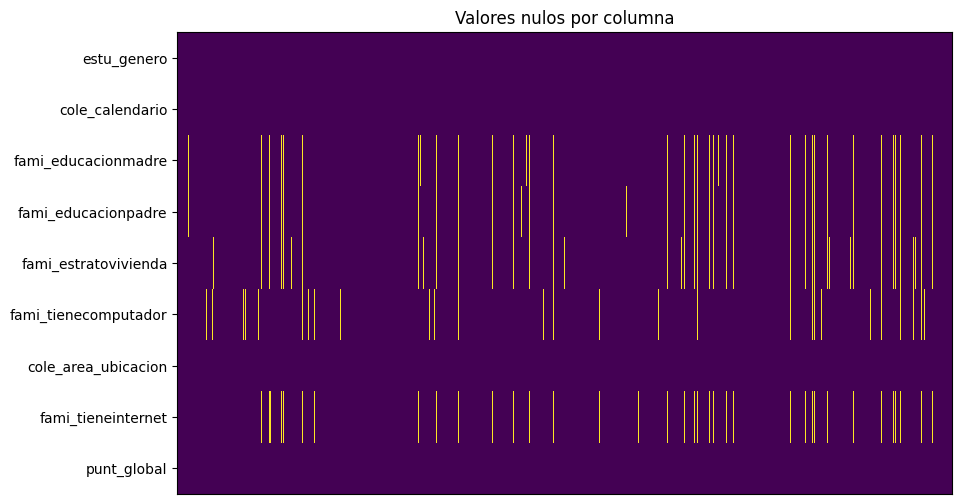

In [19]:
plot_null_vals(df_h)

In [20]:
# imputar datos faltantes con la moda
df_h = impute_mode(df_h)

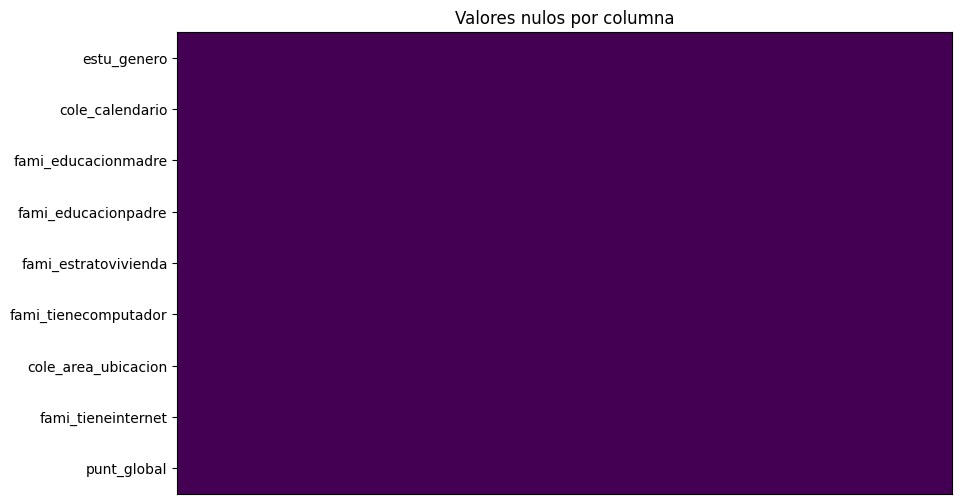

In [21]:
# verfy delete null values
plot_null_vals(df_h)

In [22]:
print("Luego de la selección arbitraria de variables, se observa un total de " + str(df_h.shape[0]) +
      " filas y " + str(df_h.shape[1]) + " columnas")

Luego de la selección arbitraria de variables, se observa un total de 500000 filas y 9 columnas


In [23]:
# print data type
data_type(df_h)

col_name,var_type
str,object
"""estu_genero""",String
"""cole_calendario""",String
"""fami_educacionmadre""",String
"""fami_educacionpadre""",String
"""fami_estratovivienda""",String
"""fami_tienecomputador""",String
"""cole_area_ubicacion""",String
"""fami_tieneinternet""",String
"""punt_global""",Int64


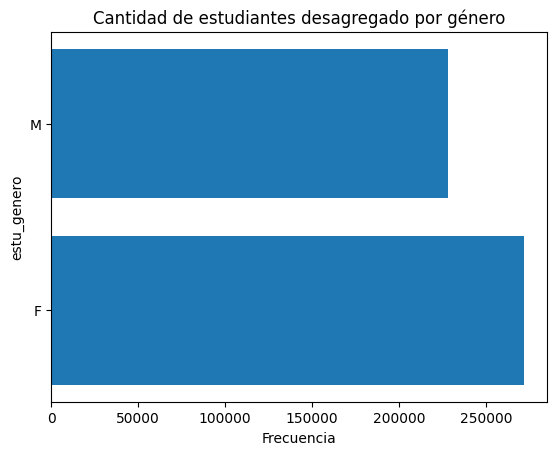

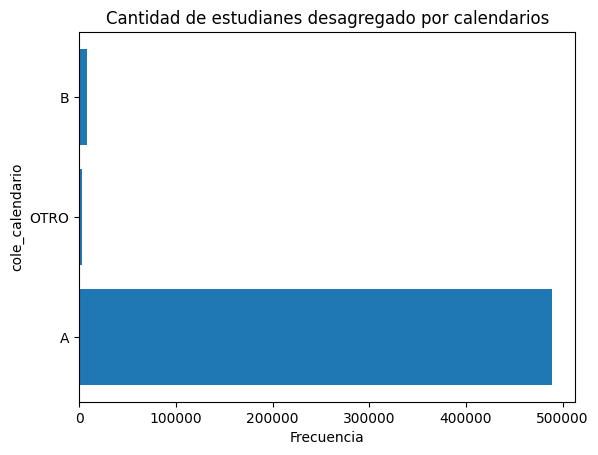

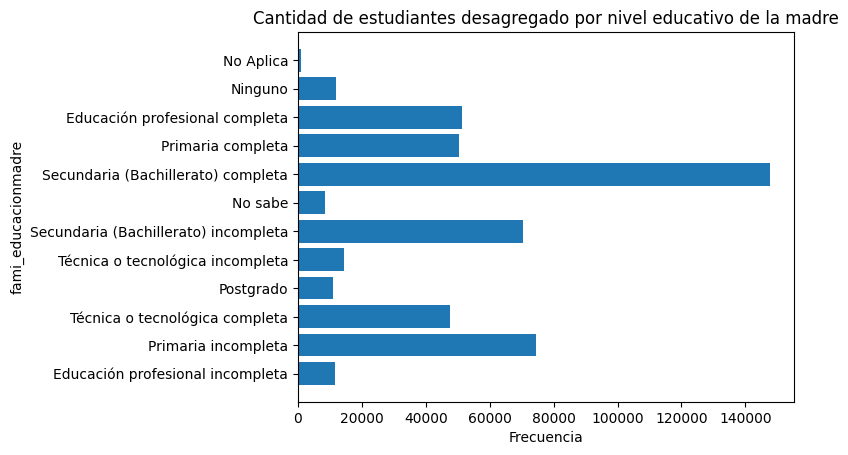

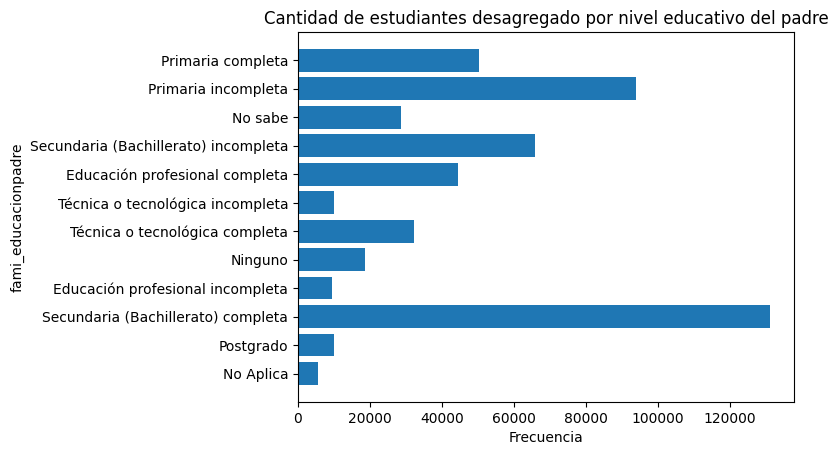

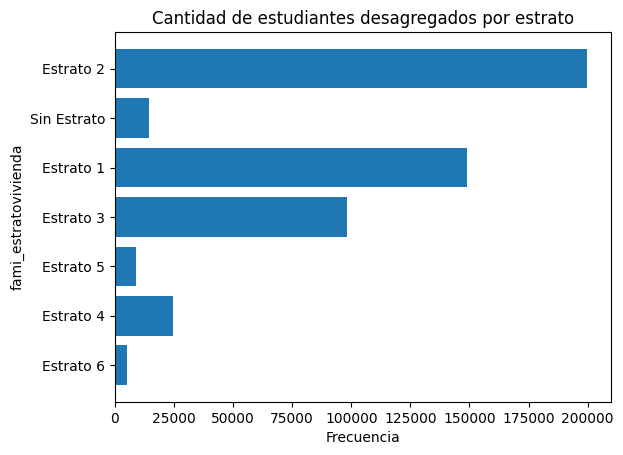

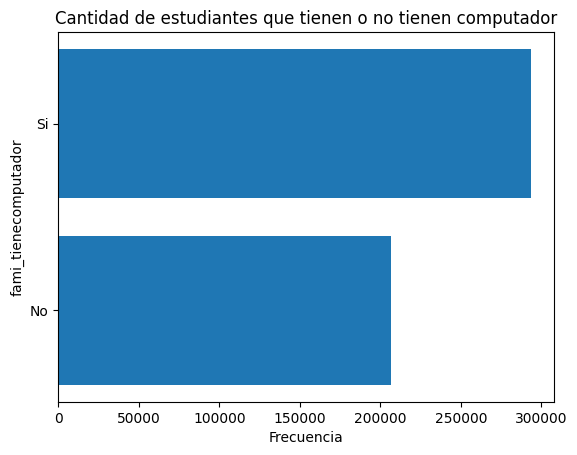

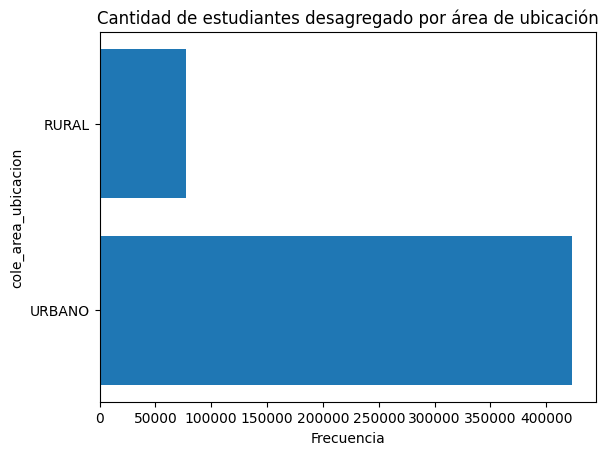

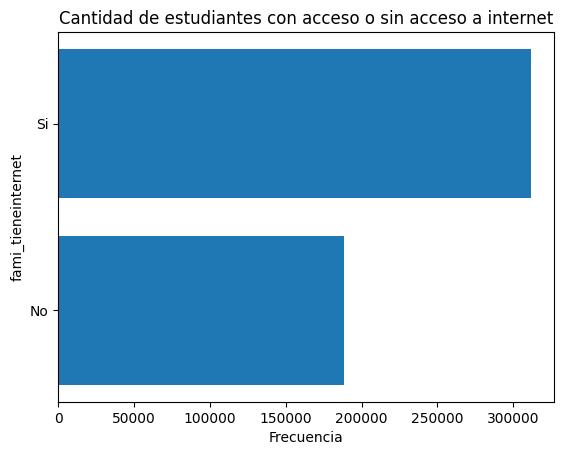

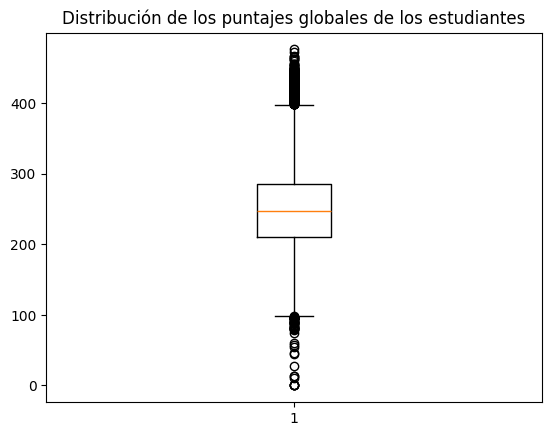

In [24]:
# plot count unique values
var_names_plot = df_h.columns
var_names_plot.remove("punt_global")

titles_plots = ["Cantidad de estudiantes desagregado por género", "Cantidad de estudianes desagregado por calendarios",
                "Cantidad de estudiantes desagregado por nivel educativo de la madre",
                "Cantidad de estudiantes desagregado por nivel educativo del padre",
                "Cantidad de estudiantes desagregados por estrato", "Cantidad de estudiantes que tienen o no tienen computador",
                "Cantidad de estudiantes desagregado por área de ubicación",
                "Cantidad de estudiantes con acceso o sin acceso a internet"]

for i in range(0, len(var_names_plot)):
    count_val = df_h[var_names_plot[i]].value_counts()

    plt.barh(count_val[var_names_plot[i]], count_val["count"])
    plt.xlabel("Frecuencia")
    plt.ylabel(var_names_plot[i])
    plt.title(titles_plots[i])
    plt.show()

plt.boxplot(df_h["punt_global"])
plt.title("Distribución de los puntajes globales de los estudiantes")
plt.show()

In [25]:
# Conteo de la cantidad de valores únicos por columna
pl.DataFrame(
    {
        "col_name": df_h.columns,
        "n_unique_values": [len(df_h[col].unique()) for col in df_h.columns]
    }
).sort("n_unique_values", descending = True)

col_name,n_unique_values
str,i64
"""punt_global""",388
"""fami_educacionmadre""",12
"""fami_educacionpadre""",12
"""fami_estratovivienda""",7
"""cole_calendario""",3
"""estu_genero""",2
"""fami_tienecomputador""",2
"""cole_area_ubicacion""",2
"""fami_tieneinternet""",2


In [26]:
homolgr_vals = {
    "Educación profesional completa" : "Pregrado",
    "Educación profesional incompleta" : "Bachillerato",
    "No Aplica" : "NS",
    "No sabe" : "NS",
    "Técnica o tecnológica completa" : "Tecnica",
    "Técnica o tecnológica incompleta": "Bachillerato",
    "Secundaria (Bachillerato) incompleta" : "Primaria",
    "Secundaria (Bachillerato) completa" : "Bachillerato",
    "Primaria completa" : "Primaria",
    "Primaria incompleta" : "Ninguno",
    "Postgrado" : "Postgrado",
    "Ninguno" : "Ninguno"
}

df_h = df_h.with_columns(
    pl.col("fami_educacionmadre").replace(homolgr_vals).alias("fami_educacionmadre"),
    pl.col("fami_educacionpadre").replace(homolgr_vals).alias("fami_educacionpadre"))

In [27]:
# Conteo de la cantidad de valores perdidos y su proporción por columna
pl.DataFrame(
    {
        "col_name": df_h.columns,
        "n_unique_values": [len(df_h[col].unique()) for col in df_h.columns]
    }
).sort("n_unique_values", descending = True)

col_name,n_unique_values
str,i64
"""punt_global""",388
"""fami_educacionmadre""",7
"""fami_educacionpadre""",7
"""fami_estratovivienda""",7
"""cole_calendario""",3
"""estu_genero""",2
"""fami_tienecomputador""",2
"""cole_area_ubicacion""",2
"""fami_tieneinternet""",2


## Fase 2: identificar características y relaciones en las variables

En esta fase realizarás análisis descriptivo para identificar posibles patrones o relaciones entre las variables de interés para la problemática planteada. Además, expondrás estadísticas descriptivas y visualizaciones para concluir al respecto de los patrones y las relaciones identificadas. Finalmente, elegirás el segmento de los datos sobre el cual profundizarás con tu análisis (este puede ser, o no, igual al seleccionado anteriormente).

Pautas generales:

* Calcular estadísticas descriptivas básicas (por lo menos, media/mediana y varianza/desviación) para cada variable sociodemográfica relevante en el contexto del problema.
* Utilizar librerías especializadas (ej., `matplotlib`, `seaborn`, etc.) para inspeccionar visualmente variables de interés. Los métodos `distplot`, `pairplot`, `boxplot`, o `violinplot`, entre otros, pueden ser útiles.
* Utilizar el método `groupby` de `pandas`, en conjunto con métodos de visualización, puede proveer evidencia del impacto de las variables sociodemográficas de interés sobre el desempeño de los estudiantes en la prueba.

Preguntas guía:

* ¿Hay patrones de interés en las distribuciones de las variables o en las relaciones entre ellas?
* ¿Consideras que existe algún impacto significativo de variables sociodemográficas en los puntajes globales o por área?
* ¿Sobre cuáles variables harías un análisis más profundo?

In [28]:
print("Una vez se realizó la lectura y procesamiento de un gran volumen de información, se procede a trasformar la tabla a un formato mucho más \
compatible con librerías de visualización y modelamiento.")

Una vez se realizó la lectura y procesamiento de un gran volumen de información, se procede a trasformar la tabla a un formato mucho más compatible con librerías de visualización y modelamiento.


In [29]:
# trasformar dataframe polars a dataframe pandas
df_h = df_h.to_pandas()

print(type(df_h))

<class 'pandas.core.frame.DataFrame'>


In [30]:
var_names_plot = df_h.drop("punt_global", axis = 1).columns

tabla = {
    col: df_h[col].value_counts().reset_index().rename(columns={"index": col, col: "clases"})
    for col in var_names_plot
}

for nombre_columna, df in tabla.items():
    print("Tabla de conteos de cada clase para la variable: " +  str(nombre_columna))
    print(df)
    print("\n")

Tabla de conteos de cada clase para la variable: estu_genero
  clases   count
0      F  271673
1      M  228327


Tabla de conteos de cada clase para la variable: cole_calendario
  clases   count
0      A  488644
1      B    8484
2   OTRO    2872


Tabla de conteos de cada clase para la variable: fami_educacionmadre
         clases   count
0  Bachillerato  173863
1      Primaria  120722
2       Ninguno   86236
3      Pregrado   51306
4       Tecnica   47463
5     Postgrado   11132
6            NS    9278


Tabla de conteos de cada clase para la variable: fami_educacionpadre
         clases   count
0  Bachillerato  150499
1      Primaria  116047
2       Ninguno  112319
3      Pregrado   44443
4            NS   34398
5       Tecnica   32135
6     Postgrado   10159


Tabla de conteos de cada clase para la variable: fami_estratovivienda
        clases   count
0    Estrato 2  199867
1    Estrato 1  148908
2    Estrato 3   98244
3    Estrato 4   24493
4  Sin Estrato   14629
5    Estrato 5   

In [31]:
# descripción general variables:
print("Con base en los gráficos anteriores, se tienen las siguientes conclusiones: \n 1) Se observa que el género solamente contiene \
dos clases y que no se tiene observaciones para identidades sexuales y género diversas. \n 2) El calendario de los colegios posee tres clases \
y se observa un marcado desbalanceo, dada la sobrerepresentación del calendario A. \n 3) Luego de la homologación de clases para la variable \
que da cuenta del nivel educativo alcanzado por la madre, se observan 7 clases.\n 4) Asimismo, para el caso del nivel educativo del padre \
también se tienen 7 clases e total.\n 5) En cuanto al estrato de la vivienda, se observan 7 clases las cuales tienden a reducir su participación \
toda vez que se aumenta el estrato socioeconómico. \n 7) El acceos a un computador solamente presenta dos clases y no se observa desbalanceo \
importante. \n 8) La ubicación de los estudiantes solamente posee dos clases y se observa un desbalanceo. No obstante, la clase RURAL posee un total\
de 77.060 registros lo cual brinda una relativa buena cantidad de observaciones.\n 9) Por último, se tiene dos clases para representar el acceso de \
los estudiantes a internet. Estas clases no poseen un marcado desbalanceo.")

Con base en los gráficos anteriores, se tienen las siguientes conclusiones: 
 1) Se observa que el género solamente contiene dos clases y que no se tiene observaciones para identidades sexuales y género diversas. 
 2) El calendario de los colegios posee tres clases y se observa un marcado desbalanceo, dada la sobrerepresentación del calendario A. 
 3) Luego de la homologación de clases para la variable que da cuenta del nivel educativo alcanzado por la madre, se observan 7 clases.
 4) Asimismo, para el caso del nivel educativo del padre también se tienen 7 clases e total.
 5) En cuanto al estrato de la vivienda, se observan 7 clases las cuales tienden a reducir su participación toda vez que se aumenta el estrato socioeconómico. 
 7) El acceos a un computador solamente presenta dos clases y no se observa desbalanceo importante. 
 8) La ubicación de los estudiantes solamente posee dos clases y se observa un desbalanceo. No obstante, la clase RURAL posee un totalde 77.060 registros lo cua

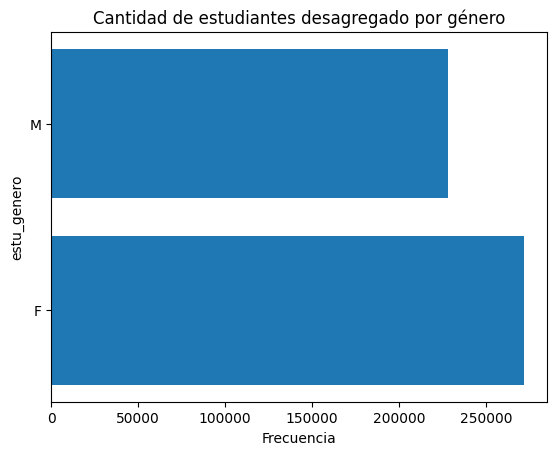

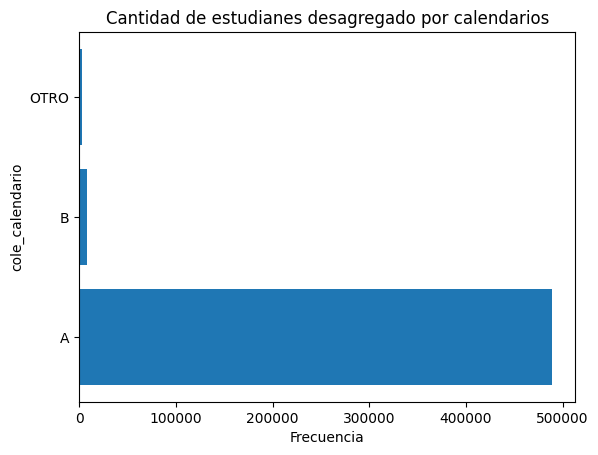

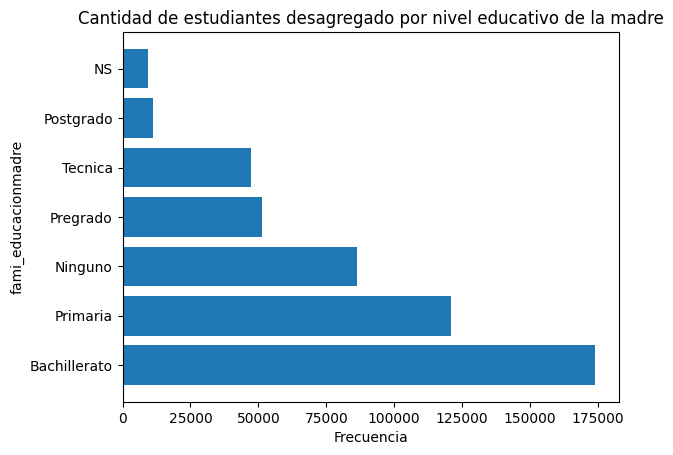

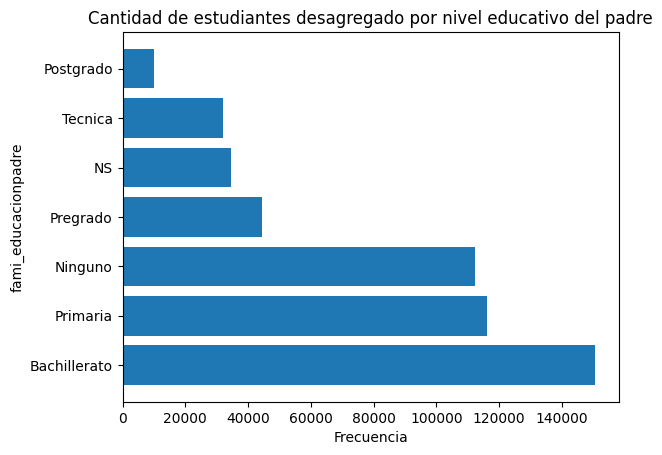

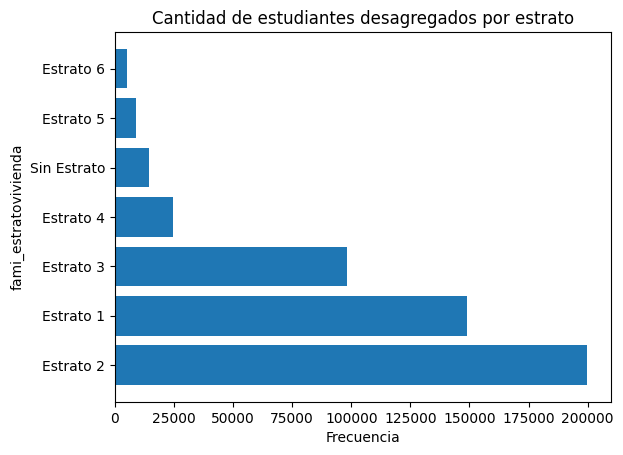

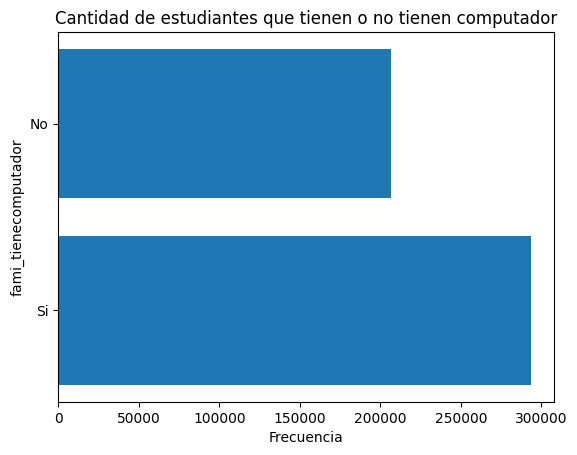

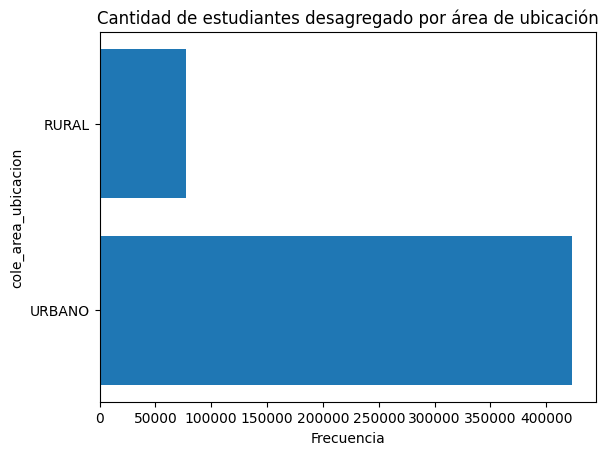

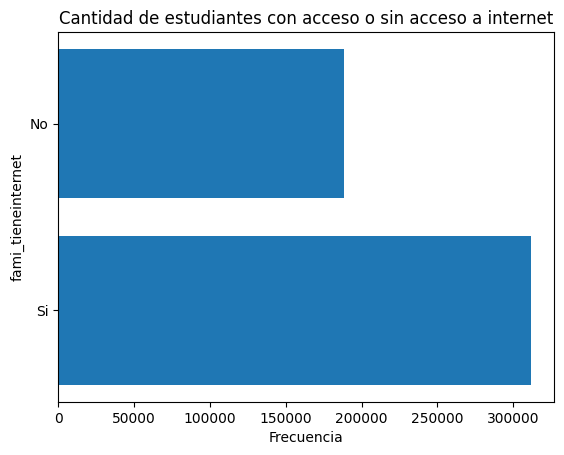

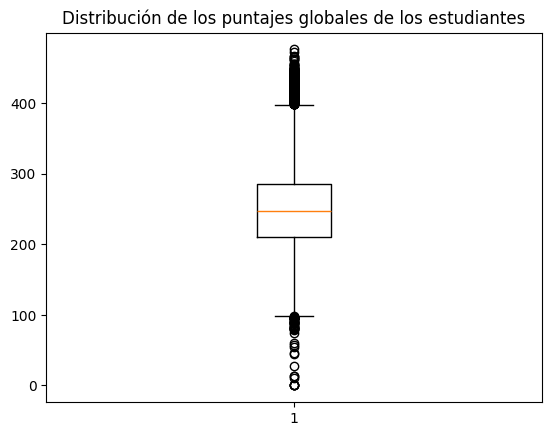

In [32]:
# Luego de aplicar las transformaciones se imprimen nuevamente los conteos por categoría y la distribución de la variable de puntaje global
var_names_plot = df_h.drop("punt_global", axis = 1).columns

titles_plots = ["Cantidad de estudiantes desagregado por género",
                "Cantidad de estudianes desagregado por calendarios",
                "Cantidad de estudiantes desagregado por nivel educativo de la madre",
                "Cantidad de estudiantes desagregado por nivel educativo del padre",
                "Cantidad de estudiantes desagregados por estrato",
                "Cantidad de estudiantes que tienen o no tienen computador",
                "Cantidad de estudiantes desagregado por área de ubicación",
                "Cantidad de estudiantes con acceso o sin acceso a internet"]

for i in range(0, len(var_names_plot)):
    count_val = df_h[var_names_plot[i]].value_counts()
    
    plt.barh(count_val.index, count_val.values)
    plt.xlabel("Frecuencia")
    plt.ylabel(var_names_plot[i])
    plt.title(titles_plots[i])
    plt.show()
    
plt.boxplot(df_h["punt_global"])
plt.title("Distribución de los puntajes globales de los estudiantes")
plt.show()

In [33]:
print("Con base en los gráficos anteriores, se tienen las siguientes conclusiones: \n 1) Se observa un marcado \
desbalanceo entre las distintas clases del calendario. \n 2) No existe una diferencia muy marcada entre la cantidad de personas \
del género masculino y las personas del género femenino. \n 3) La moda para la variable del grado nivel educativo más alto alcanzado por \
la madre es Bachillerato. \n 4) La moda para la variable del grado nivel educativo más alto alcanzado por el padre es Bachillerato. \n 5) \
La moda para el estrato socioeconómico de la vivienda es el estrato 2. \n 6) Se observa más estudiantes con conputador que sin computador. \n 7) \
La mayoría de los estudiantes tiene su lugar de residencia en lo urbano. \n 8) Se observa más estudiantes con acceso a internet que sin acceso. \n \
9) Se boserva que el valor típico de los puntajes de los estudiantes se ubica al rededor de 250 puntos. Asimismo, la caja es relativamente \
simétrica, lo cuál sugiere que la distribución de los puntajes es simetrica al rededor de la mediana. Asimismo, también se observan bastantes puntos \
atípicos inferiores y superiores, lo cual da cuenta de estudiantes con puntajes muy sobresalientes y estudiantes con desmepeños deficientes.")

Con base en los gráficos anteriores, se tienen las siguientes conclusiones: 
 1) Se observa un marcado desbalanceo entre las distintas clases del calendario. 
 2) No existe una diferencia muy marcada entre la cantidad de personas del género masculino y las personas del género femenino. 
 3) La moda para la variable del grado nivel educativo más alto alcanzado por la madre es Bachillerato. 
 4) La moda para la variable del grado nivel educativo más alto alcanzado por el padre es Bachillerato. 
 5) La moda para el estrato socioeconómico de la vivienda es el estrato 2. 
 6) Se observa más estudiantes con conputador que sin computador. 
 7) La mayoría de los estudiantes tiene su lugar de residencia en lo urbano. 
 8) Se observa más estudiantes con acceso a internet que sin acceso. 
 9) Se boserva que el valor típico de los puntajes de los estudiantes se ubica al rededor de 250 puntos. Asimismo, la caja es relativamente simétrica, lo cuál sugiere que la distribución de los puntajes es simet

In [34]:
# Estadísticas descriptivas para la variable de respuesta:
df_h["punt_global"].describe()

count    500000.000000
mean        250.154332
std          51.290681
min           0.000000
25%         211.000000
50%         247.000000
75%         286.000000
max         476.000000
Name: punt_global, dtype: float64

In [35]:
# Eliminar la variable del calendario debido al marcado desbalanceo entre clases
df_h = df_h.drop("cole_calendario", axis = 1)

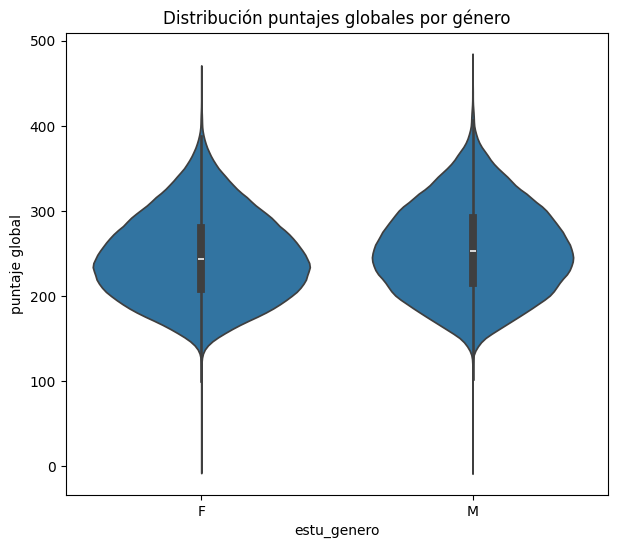

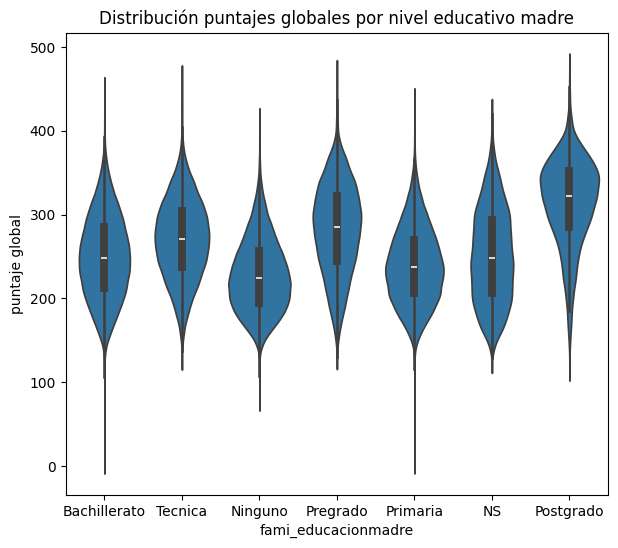

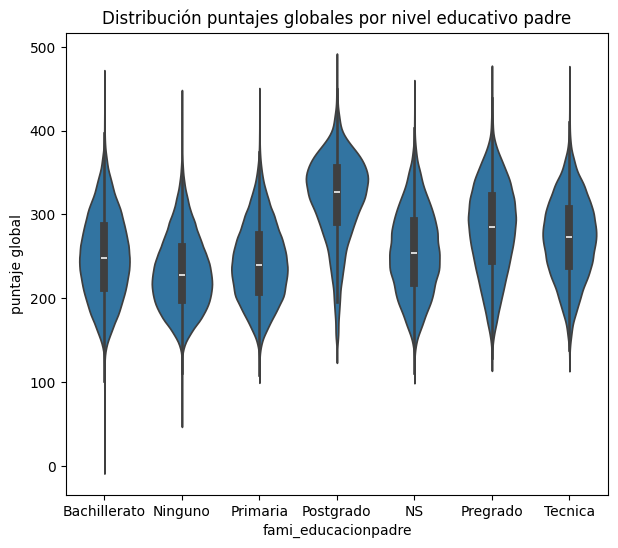

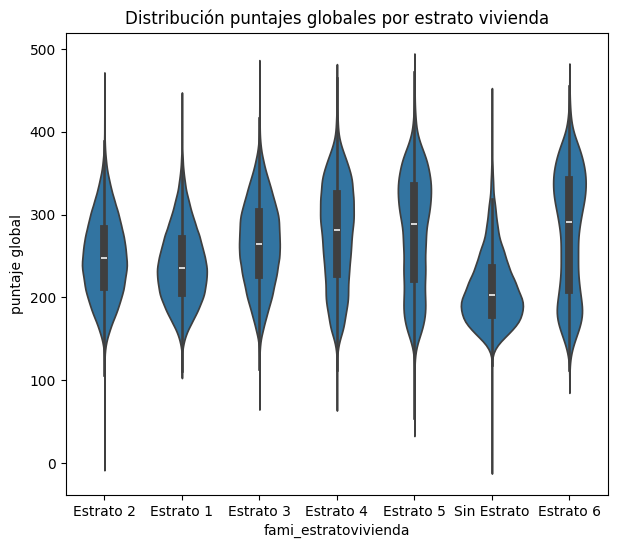

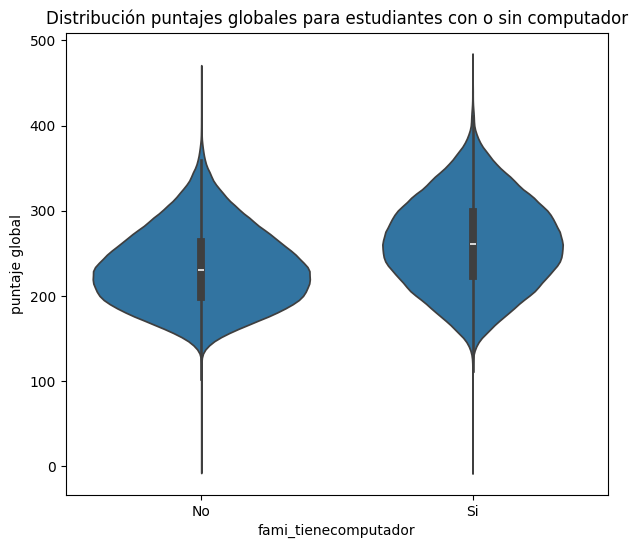

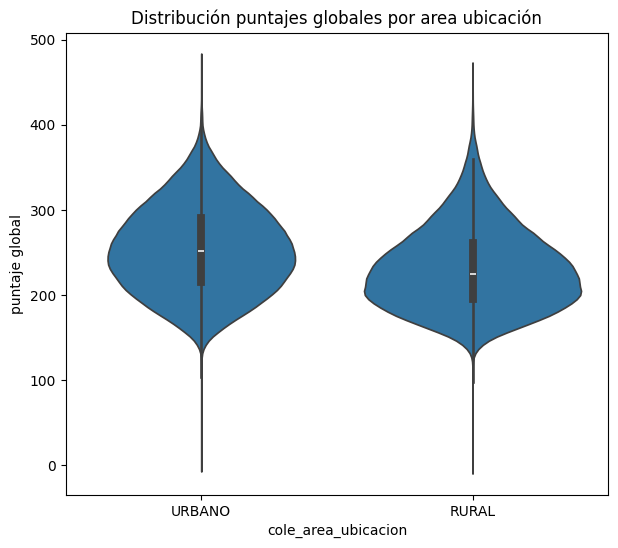

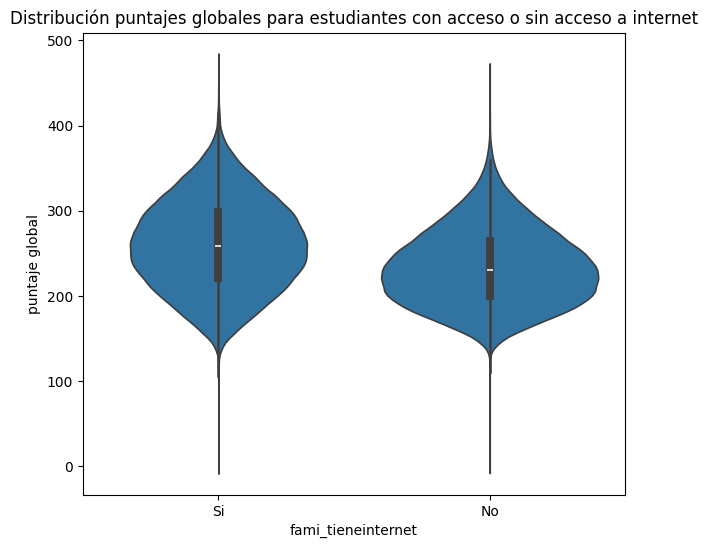

In [36]:
titls_graphs = ["Distribución puntajes globales por género",
                "Distribución puntajes globales por nivel educativo madre",
                "Distribución puntajes globales por nivel educativo padre",
                "Distribución puntajes globales por estrato vivienda",
                "Distribución puntajes globales para estudiantes con o sin computador",
                "Distribución puntajes globales por area ubicación",
                "Distribución puntajes globales para estudiantes con acceso o sin acceso a internet"]

cols_X = df_h.drop("punt_global", axis = 1).columns

for i in range(0, len(cols_X)):
    plt.figure(figsize=(7, 6))
    sns.violinplot(x = cols_X[i], y = "punt_global", data = df_h)
    plt.xlabel(cols_X[i])
    plt.ylabel("puntaje global")
    plt.title(titls_graphs[i])
    plt.show()

In [37]:
print("Con base en los gráficos anteriores, se tienen las siguientes intuiciones con respecto a variables que podrían explicar las diferencias \
en los puntajes de los estudiantes: \n 1) No se observa que las variaciones en los valores del género tengan su correlato \
en diferencias marcadas en los puntajes de los estudiantes. \n 2) Se observa que el nivel educativo más alto alcanzado por la madre \
parece tener un impacto en el buen desempeño de los estudiantes. La dirección de este efecto parece indicar que, a mayor nivel educativo \
de la madre, incrementa el desempeño de los estudiantes en términos de su puntaje global. \n 3) La variable del nivel educativo del padre \
parece tener un efecto similar al del nivel educativo de la madre. Los gráficos aparentemente indicarían que la distribución de los puntajes de \
los estudiantes varía de acuerdo al nivel educativo del padre. \n 4) El estrato también se perfila cómo una variable que permititía predecir \
el el desempeño de los estudiantes. Los mayores puntajes globales parecen presentarse en estratos más altos. Sin embargo, a medida que aumenta \
el estrato también parece aumentar la varianza de los puntajes. \n 5) El acceso a un computador también muestra diferencias en los puntajes; no \
obstante, estas diferencias -a primera vista- no parecen ser demasiado grandes como para afirmar que explicarían diferencias significativas en \
los puntajes de los estudiantes. \n 6) Con respecto a la ubicación rural o urbana de los estudiantes también se observa una leve diferencia \
en los puntajes globales de los estudiantes. \n 8) El acceso o no acceso a internet también expone una pequeña diferencia en los puntajes globales.")

Con base en los gráficos anteriores, se tienen las siguientes intuiciones con respecto a variables que podrían explicar las diferencias en los puntajes de los estudiantes: 
 1) No se observa que las variaciones en los valores del género tengan su correlato en diferencias marcadas en los puntajes de los estudiantes. 
 2) Se observa que el nivel educativo más alto alcanzado por la madre parece tener un impacto en el buen desempeño de los estudiantes. La dirección de este efecto parece indicar que, a mayor nivel educativo de la madre, incrementa el desempeño de los estudiantes en términos de su puntaje global. 
 3) La variable del nivel educativo del padre parece tener un efecto similar al del nivel educativo de la madre. Los gráficos aparentemente indicarían que la distribución de los puntajes de los estudiantes varía de acuerdo al nivel educativo del padre. 
 4) El estrato también se perfila cómo una variable que permititía predecir el el desempeño de los estudiantes. Los mayores puntaj

In [38]:
# Tablas para la representación de relaciones entre pares de variables que podrías ser relevantes para el ejercicio:
# Estrato vivienda vs Nivel educativo alcanzado por la madre
pd.crosstab(df_h['fami_estratovivienda'], df_h['fami_educacionmadre'], normalize='index')

fami_educacionmadre,Bachillerato,NS,Ninguno,Postgrado,Pregrado,Primaria,Tecnica
fami_estratovivienda,,,,,,,
Estrato 1,0.269663,0.014949,0.289890,0.003680,0.039031,0.312596,0.070191
Estrato 2,0.432007,0.016251,0.136561,0.009466,0.074394,0.235372,0.095949
Estrato 3,0.353335,0.022984,0.081684,0.037600,0.181599,0.181813,0.140986
Estrato 4,0.259299,0.027191,0.068387,0.111134,0.313028,0.118932,0.102029
Estrato 5,0.213751,0.025266,0.071772,0.145556,0.325433,0.142985,0.075238
Estrato 6,0.200244,0.027473,0.076109,0.181115,0.318478,0.143061,0.053521
Sin Estrato,0.232688,0.035477,0.345820,0.005742,0.043817,0.298995,0.037460


In [39]:
# Tablas para la representación de relaciones entre pares de variables que podrían ser relevantes para el ejercicio:
# Estrato vivienda vs Nivel educativo alcanzado por el padre
pd.crosstab(df_h['fami_estratovivienda'], df_h['fami_educacionpadre'], normalize='index')

fami_educacionpadre,Bachillerato,NS,Ninguno,Postgrado,Pregrado,Primaria,Tecnica
fami_estratovivienda,,,,,,,
Estrato 1,0.214703,0.065994,0.359034,0.002995,0.035693,0.279065,0.042516
Estrato 2,0.380103,0.065704,0.188405,0.007525,0.062076,0.230999,0.065188
Estrato 3,0.316681,0.081583,0.116882,0.031177,0.154839,0.197803,0.101034
Estrato 4,0.242477,0.065733,0.091536,0.104969,0.287960,0.133793,0.073531
Estrato 5,0.201901,0.055338,0.107099,0.155618,0.291112,0.136501,0.052432
Estrato 6,0.198006,0.050468,0.119658,0.219984,0.259870,0.109076,0.042939
Sin Estrato,0.186479,0.073211,0.405291,0.006972,0.039305,0.263586,0.025156


In [40]:
# Tablas para la representación de relaciones entre pares de variables que podrían ser relevantes para el ejercicio:
# Área de ubicación del colegio vs Acceso a internet
pd.crosstab(df_h['cole_area_ubicacion'], df_h['fami_tieneinternet'], normalize='index')

fami_tieneinternet,No,Si
cole_area_ubicacion,,
RURAL,0.682728,0.317272
URBANO,0.321466,0.678534


In [41]:
# Tablas para la representación de relaciones entre pares de variables que podrían ser relevantes para el ejercicio:
# Área de ubicación del colegio vs Acceso a internet
pd.crosstab(df_h['cole_area_ubicacion'], df_h['fami_tieneinternet'], normalize='index')

fami_tieneinternet,No,Si
cole_area_ubicacion,,
RURAL,0.682728,0.317272
URBANO,0.321466,0.678534


In [42]:
# Tablas para la representación de relaciones entre pares de variables que podrían ser relevantes para el ejercicio:
# Área de ubicación del colegio vs Acceso a internet
pd.crosstab(df_h['fami_educacionmadre'], df_h['fami_educacionpadre'], normalize='index')

fami_educacionpadre,Bachillerato,NS,Ninguno,Postgrado,Pregrado,Primaria,Tecnica
fami_educacionmadre,,,,,,,
Bachillerato,0.515941,0.057045,0.110213,0.007477,0.061790,0.186756,0.060778
NS,0.138607,0.553675,0.083100,0.011317,0.065962,0.101638,0.045700
Ninguno,0.092398,0.050420,0.629795,0.000939,0.009741,0.207373,0.009335
Postgrado,0.153072,0.062343,0.019044,0.420589,0.219727,0.057043,0.068182
Pregrado,0.235957,0.069641,0.039469,0.057264,0.406541,0.093595,0.097532
Primaria,0.186967,0.059649,0.269918,0.001996,0.023774,0.429897,0.027799
Tecnica,0.319428,0.074311,0.068538,0.017108,0.127973,0.156248,0.236395


In [43]:
print("Con respecto a las tablas que brindan información sobre algunos pares de variables que podrían ser relevantes para \
el ejercicio, se observa que: \n \
1) Al aumentar el nivel educativo de la madre o del padre, pareciera observarse que también incrementa el estrato de la vivienda al cual \
pertenece el estudiante. A manera de ilustración, la mayor proporción de padres con posgrado se relacionan con el estrato 6. \n 2) Los hogares que \
se ubican en la ruralidad tienden a tener un acceso más restringido al servicio de internet. \n 3) En cuanto al nivel educativo alcanzado por \
los padres, se observa una aparente relación con en el nivel educativo alcanzado por ambos padres. Los padres con cierto nivel educativo \
parecen tener su correlato en el mismo nivel educativo de las madres.")

Con respecto a las tablas que brindan información sobre algunos pares de variables que podrían ser relevantes para el ejercicio, se observa que: 
 1) Al aumentar el nivel educativo de la madre o del padre, pareciera observarse que también incrementa el estrato de la vivienda al cual pertenece el estudiante. A manera de ilustración, la mayor proporción de padres con posgrado se relacionan con el estrato 6. 
 2) Los hogares que se ubican en la ruralidad tienden a tener un acceso más restringido al servicio de internet. 
 3) En cuanto al nivel educativo alcanzado por los padres, se observa una aparente relación con en el nivel educativo alcanzado por ambos padres. Los padres con cierto nivel educativo parecen tener su correlato en el mismo nivel educativo de las madres.


In [44]:
# Eliminar la variable del nivel educativo del padre debido a que sería redundante con el nivel educativo de la madre
# Además, ambos se distribuyen de manera similar en relación con la variable del puntaje global
df_h = df_h.drop("fami_educacionpadre", axis = 1)

## Fase 3: abordar relación variables-desempeño a través de un modelo

En esta fase propondrás, implementarás y reportarás el desempeño de uno o más modelos (al menos uno predictivo) que busquen explicar las relaciones entre factores sociodemográficos y el desempeño en la prueba. Además, concluirás con respecto a la validez de al menos un modelo y los posibles hallazgos que se podrían reportar para el *stakeholder*.

Pautas generales:

* Seleccionar variables y proponer modelos acordes a estas y al contexto del problema.
* Utilizar librerías especializadas (ej., `statsmodels`, `sklearn`, etc.) para indagar sobre los aspectos que contribuyen al éxito de los estudiantes. Los módulos correspondientes a regresión lineal y regresión logística pueden ser útiles.
* Asegurar el cumplimiento de los supuestos y buenas prácticas de cada modelo.
* Utilizar las métricas de evaluación de desempeño (disponibles en las librerías especilizadas), para concluir sobre la validez de los modelos propuestos.

Preguntas guía:

* ¿Existe algún sub-conjunto de variables socio-demográficas que explique razonablemente bien el desempeño de los estudiantes en la prueba?

In [45]:
print("Una vez se realiza la selección arbitratia de variables etendiendo al enfoque interseccional anteriormente expuesto, \
se procede con la generación de visualizaciones y estadísticas descriptivas. Estas herramientas permitieron depurar variables \
en virtud del desbalanceo de clases (calendario) y la redundacia que estaría aportando (nivel educativo del padre) a los modelos \
que más adelante se implementarán. A continuación, se presentan las variables con las que se busca implementar mútiples modelos predictivos:")

df_h.head()

Una vez se realiza la selección arbitratia de variables etendiendo al enfoque interseccional anteriormente expuesto, se procede con la generación de visualizaciones y estadísticas descriptivas. Estas herramientas permitieron depurar variables en virtud del desbalanceo de clases (calendario) y la redundacia que estaría aportando (nivel educativo del padre) a los modelos que más adelante se implementarán. A continuación, se presentan las variables con las que se busca implementar mútiples modelos predictivos:


,estu_genero,fami_educacionmadre,fami_estratovivienda,fami_tienecomputador,cole_area_ubicacion,fami_tieneinternet,punt_global
0,F,Bachillerato,Estrato 2,No,URBANO,Si,218
1,M,Bachillerato,Estrato 2,Si,URBANO,No,255
2,F,Bachillerato,Estrato 1,No,URBANO,No,203
3,F,Tecnica,Estrato 3,Si,URBANO,No,337
4,F,Ninguno,Estrato 2,No,URBANO,No,208


In [46]:
# Se busca predecir el desempeño exitoso de los estudiantes a partir de su puntaje global den el icfes. Por tanto se crea
# una variable de respuesta que indique si el estudiante estuvo entre el 30% de los mejores puntajes.
df_int = df_h.copy()

umbral_desmp = 0.7

df_h["desempenio_sobreslnt"] = np.where(df_h['punt_global'] >= df_h["punt_global"].quantile(umbral_desmp), 1, 0)

# Se elimina variable de respuesta cuantitativa
df_h = df_h.drop("punt_global", axis = 1)

In [47]:
XTotal = df_h.drop("desempenio_sobreslnt", axis = 1)
yTotal = df_h["desempenio_sobreslnt"]

In [48]:
XTrain, XTest, yTrain, yTest = train_test_split(XTotal, yTotal, test_size=0.30, random_state = 0)

In [49]:
auc_results = []

for r in range(1, len(XTotal.columns) + 1):
    for combinacion in combinations(XTotal.columns, r):

        clfTree = DecisionTreeClassifier()
        
        X_train_subset = XTrain[list(combinacion)]
        X_test_subset = XTest[list(combinacion)]

        X_train_subset_dumm = pd.get_dummies(X_train_subset)
        X_train_subset_dumm = X_train_subset_dumm.astype(int)
        X_test_subset_dumm = pd.get_dummies(X_test_subset)
        X_test_subset_dumm = X_test_subset_dumm.astype(int)

        clfTree.fit(X_train_subset_dumm, yTrain)

        prediccionTree=clfTree.predict_proba(X_test_subset_dumm)[:,0]
        fpr, tpr, thresholds = metrics.roc_curve(yTest, prediccionTree, pos_label = 1)
        AUCrf = metrics.auc(fpr, tpr)
        if len(combinacion) == 1:
            auc_results.append({
                "variables": combinacion[0],
                "auc": AUCrf})
        else:
            auc_results.append({
                "variables": combinacion,
                "auc": AUCrf})

In [50]:
max_auc_entry = max(auc_results, key=lambda x: x['auc'])
max_auc_variables = max_auc_entry['variables']

In [51]:
# Calcular nuevamente el mejor modelo a la luz del AUC a fin de presentar nuevas métricas
XTotal_best = XTotal[max_auc_variables]

XTrain_b_rf, XTest_b_rf, yTrain_b_rf, yTest_b_rf = train_test_split(XTotal_best, yTotal, test_size=0.30, random_state=0)

clfTree = DecisionTreeClassifier()

X_train_dumm = pd.get_dummies(XTrain_b_rf)
X_test_dumm = pd.get_dummies(XTest_b_rf)

clfTree.fit(X_train_dumm, yTrain_b_rf)

prediccionTree=clfTree.predict_proba(X_test_dumm)[:,0]
prediccionTree_val=clfTree.predict(X_test_dumm)
fpr, tpr, thresholds = metrics.roc_curve(yTest_b_rf, prediccionTree, pos_label = 1)
AUCrf = metrics.auc(fpr, tpr)

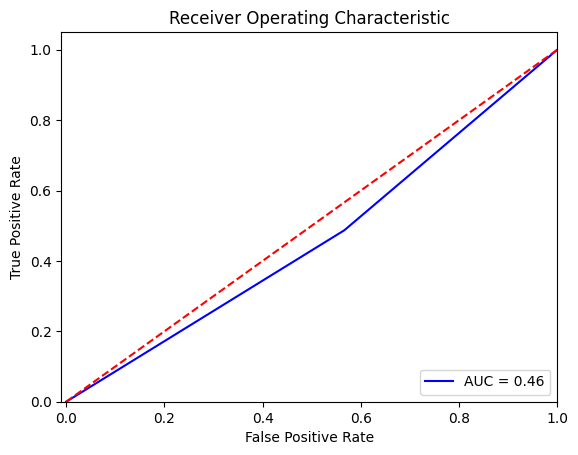

In [52]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % AUCrf)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

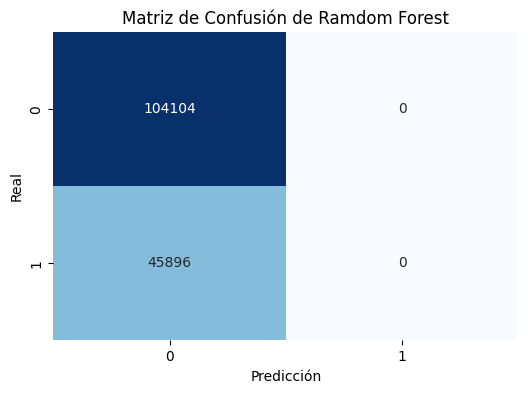

In [53]:
cm_Tree = confusion_matrix(yTest_b_rf, prediccionTree_val)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_Tree, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión de Ramdom Forest")
plt.show()

In [54]:
# Métricas del desempeño del modelo
#Precisión
precision_dt = cm_Tree[1,1]/(cm_Tree[1,1]+cm_Tree[0,1])
print("Precisión: ", precision_dt)
#Accuracy
accuracy_dt = accuracy_score(y_true = yTest_b_rf, y_pred = prediccionTree_val)
print("Accuracy: ",accuracy_dt)
#Especificidad
especificidad_dt = cm_Tree[0,0]/(cm_Tree[0,0]+cm_Tree[0,1])
print("Especificidad: ",especificidad_dt)
#Sensibilidad
sensibilidad_dt = cm_Tree[1,1]/(cm_Tree[1,1]+cm_Tree[1,0])
print("Sensibilidad: ",sensibilidad_dt)

Precisión:  nan
Accuracy:  0.6940266666666667
Especificidad:  1.0
Sensibilidad:  0.0


C:\Users\sebas\AppData\Local\Temp\ipykernel_11616\1411600800.py:3: RuntimeWarning: invalid value encountered in scalar divide
  precision_dt = cm_Tree[1,1]/(cm_Tree[1,1]+cm_Tree[0,1])


In [55]:
print("A continuación, se presentan algunas conclusiones sobre el ejercicio anterior: \n \
1) Se corrieron de manera iterativa un total de 63 modelos para todas las combinaciones posibles de 1, 2, 3, 4, 5 y 6 variables predictoras. \n 2) Se \
filtró el mejor de los 63 modelos a partir de la métrica del AUC. El modelo con mejor AUC fue aquel que solamente tuvo en cuenta \
la variable del género de los estudiantes.\n 3) El modelo calculó acertadamente 104.104 casos donde el estudiante no tuvo un desempeño \
sobresaliente. 4) El modelo calculó incorrectamente 45.896 casos donde el estudiante habría tenido un desempeño sobresaliente, pero el modelo \
predijo un desempeño no sobresaliente. \n 5) El modelo no predijo ningún caso de desempeño sobresaliente ni correctamente ni incorrectamente. \n \
6) La Precisión del modelo fue nan (not a number) debido a que, al calcular esta métrica, se obtiene una división por cero. \n 7) El Accuracy \
del modelo fue de 0.694, lo cuál indica que clasificó correctamente el 69.4% de todas las observaciones. \n 8) La especificidad del modelo fue de \
1.0 debido a que el modelo clasificó correctamente todos los casos donde no se presentaba un buen desempeño. \n 9) El AUC del modelo fue de 0.46, lo \
cual, sumado a las métricas anteriormente expuestas, indica que el modelo tiene un desempeño predictivo deficiente. 10) El modelo se encuentra \
completamente sesgado hacia la clase mayoritaria la cual corresponde a puntajes que no reflejan un buen desempeño en el puntaje del ICFES.")

A continuación, se presentan algunas conclusiones sobre el ejercicio anterior: 
 1) Se corrieron de manera iterativa un total de 63 modelos para todas las combinaciones posibles de 1, 2, 3, 4, 5 y 6 variables predictoras. 
 2) Se filtró el mejor de los 63 modelos a partir de la métrica del AUC. El modelo con mejor AUC fue aquel que solamente tuvo en cuenta la variable del género de los estudiantes.
 3) El modelo calculó acertadamente 104.104 casos donde el estudiante no tuvo un desempeño sobresaliente. 4) El modelo calculó incorrectamente 45.896 casos donde el estudiante habría tenido un desempeño sobresaliente, pero el modelo predijo un desempeño no sobresaliente. 
 5) El modelo no predijo ningún caso de desempeño sobresaliente ni correctamente ni incorrectamente. 
 6) La Precisión del modelo fue nan (not a number) debido a que, al calcular esta métrica, se obtiene una división por cero. 
 7) El Accuracy del modelo fue de 0.694, lo cuál indica que clasificó correctamente el 69.4% de t

## Fase 4

Deberás elegir y realizar una de las dos alternativas que se encuentran a continuación.

### Alternativa 1: desarrollar una herramienta interactiva de análisis

En esta fase desarrollarás, a partir de alguno de los análisis realizados, una herramienta interactiva que sea relevante en el contexto del problema, acompañada de las instrucciones necesarias para que un usuario la pueda utilizar.

Pautas generales:

* Seleccionar uno de los análisis previos que pueda verse enriquecido con alguna característica de interactividad.
* Seleccionar el/los parámetro(s) que el usuario podrá cambiar.
* Desarrollar las funciones que se deben ejecutar con cada acción del usuario.
* Utilizar una librería especializada (ej., `ipywidgets`, `panel`, etc.) para implementar la herramienta.

Preguntas guía:

* ¿Cuál o cuáles preguntas podrá hacerle el usuario a la herramienta y cómo aporta la respuesta al análisis?
* ¿Qué aprendizajes clave puede explorar u obtener el usuario con esta herramienta?

In [56]:
checkbox1 = [widgets.Checkbox(value=True, description = col) for col in XTrain.columns]

# umbral desempeño de estudiantes
umbral_pos_desemp = widgets.FloatSlider(
    value = 0.5,
    min = 0.5,
    max = 1.0,
    step = 0.1,
    description='Umbral:',
    disabled=False,
    continuous_update=False,
    orientation='vertical')

butn = widgets.Button(description = "Ejecutar modelo RF")

output = widgets.Output()

def rf_model(button):

    df_tab = df_int.copy()

    output.clear_output(wait = True)
    X_pred = [box.description for box in checkboxes if box.value]

    clfTree = DecisionTreeClassifier()

    umbral_desmp = umbral_pos_desemp
    
    df_tab["desempenio_sobreslnt"] = np.where(df_tab['punt_global'] >= df_tab["punt_global"].quantile(umbral_desmp), 1, 0)

    df_tab = df_tab.drop("punt_global", axis = 1)

    X_tr_select = XTrain[X_pred]
    X_te_select = XTest[X_pred]

    
    
    



checkbox2 = widgets.Checkbox(value=False, description='cos(x)')


,estu_genero,fami_educacionmadre,fami_estratovivienda,fami_tienecomputador,cole_area_ubicacion,fami_tieneinternet,punt_global
0,F,Bachillerato,Estrato 2,No,URBANO,Si,218
1,M,Bachillerato,Estrato 2,Si,URBANO,No,255
2,F,Bachillerato,Estrato 1,No,URBANO,No,203
3,F,Tecnica,Estrato 3,Si,URBANO,No,337
4,F,Ninguno,Estrato 2,No,URBANO,No,208


In [57]:
XTrain, XTest, yTrain, yTest = train_test_split(XTotal, yTotal, test_size=0.30, random_state = 0)

### Alternativa 2: registrar en bases de datos relacionales con PySpark

En esta fase desarrollarás, a partir de alguno de los análisis realizados, un _script_ que sea relevante en el contexto del problema, acompañado de las instrucciones necesarias para que un usuario lo pueda ejecutar.

Pautas generales:

* Cargar en una base de datos relacional (tipo SQL) el segmento de los datos sobre el cual profundizaste en tu anális, utilizando una tabla distinta para cada categoría de campos. Por ejemplo, una categoría puedes ser información del colegio; en cuyo caso, una tabla debería contener un registro único para cada colegio y todos los campos asociados.

* Los campos, a excepción de los identificadores, deben existir en un única tabla.

* Cada registro debe existir una única vez en su respectiva tabla.

* Cada registro debe tener un identificador único en su tabla, el cual establece una relación entre tablas.

* Seleccionar uno de los modelos predictivos implementados.

* Crear en la base de datos relacional una tabla que contenga únicamente los identificadores del registro y la predicción de la variable de respuesta hecha por el modelo.

* Desarrollar _queries_ de SQL según las siguientes indicaciones y concluir acerca de los resultados:
    * Un _query_ que seleccione todos registros y los agregue en una única tabla. Para esto debes relacionar las tablas por su identificador, utilizando el método `JOIN`.
    * Un _query_ que contenga el puntaje promedio de los estudiantes, agrupado por año y por colegio.
    * Distintos _queries_ que calculen medidas de error de predicción del modelo a partir de los datos reales y las predicciones respectivas. Debes reportar el error para cada registro, el error total de los registros de entrenamiento y el error total de los registros de prueba.
    * Haz dos _queries_ adicionales que resulten interesantes.

Preguntas guía:

* ¿Cómo aporta la segmentación de los datos en categorías de campos al manejo de los datos?
* ¿Qué filtros y agrupaciones podemos aplicar sobre los datos con el fin de obtener información relevante?

## Referencias

*  J. VanderPlas (2016) *Python Data Science Handbook: Essential Tools for Working with Data* O'Reilly Media, Inc.
*  scikit-learn developers . (2020). Demo of DBSCAN clustering algorithm. 11 Diciembre 2020, de scikit-learn <br> https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py

## Créditos

__Autores__: Camilo Hernando Gómez Castro, Alejandro Mantilla Redondo, Jose Fernando Barrera de Plaza, Diego Alejandro Cely Gómez.

__Fecha última actualización__: 29/09/2022